In [44]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets

from eda_utils import MultiVariate_TS_EDA
from ts_clustering import Multivariate_TS_Clustering

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read the data

In [45]:
# fill this simple config file with your data details
config = {'seq_data_path' : 'data/batch_data_5K_120_seq_v2.csv', 
          'static_data_path' : 'data/batch_data_5K_static_v2.csv',
          "seq_identifier_col" : 'BATCH_ID', 
          "time_step_col" : 'TIME_STEP',
          "cols_to_drop" : "PROCESS"}

In [46]:
meta_data = pd.read_csv(config['static_data_path'])

print("-"*50 + "\n Meta-data details (optional): \n" + "-"*50)
print(">> Overall shape of the data:  ", meta_data.shape)
print(">> No. of unique seqs =  ", meta_data[config['seq_identifier_col']].nunique())
print("\n\n >> Meta-data sample: \n")
meta_data.head()

--------------------------------------------------
 Meta-data details (optional): 
--------------------------------------------------
>> Overall shape of the data:   (176, 13)
>> No. of unique seqs =   176


 >> Meta-data sample: 



BATCH_ID  CA CHLORIDE DIHYDRATE USP/EP  EDTA IRONIII DERIV SODIUM SALT  \
0  J0417001                       732.000                          30.150   
1  J0417002                       733.000                          30.018   
2  J0417003                       727.000                          29.934   
3  J0417005                       730.155                          30.021   
4  J0417006                       731.000                          30.016   

   GLUCOSE DEXTR ANHYDROUS USP/EP  LCYSTEINE HYDRCHL MOHYD USP/EP  \
0                         61524.0                          1057.0   
1                         61369.0                          1056.0   
2                         61367.0                          1059.0   
3                         61500.0                          1056.0   
4                         61508.0                          1055.0   

   MAGNESIUM SULFATE HEPHY USP/EP  MR-2  BASAL MEDIUM  POLOXAMER 188, NF/EP  \
0                         403.000           11586.000                2050.0   
1                         402.463           11580.208                2060.0   
2                         401.705           11590.000                2058.0   
3                         403.184           11590.000                2050.0   
4                         403.000           11590.000                2059.0   

   POTASSIUM CHLORIDE, USP/EP  SODIUM BICARBONATE, USP, EP  \
0                       533.0                       2048.0   
1                       535.0                       2043.0   
2                       532.0                       2038.0   
3                       531.0                       2051.0   
4                       533.0                       2053.0   

   SODIUM CHLORIDE, USP/EP  TC YEASTOLATE UF  1250L_VCC_END  
0                  10301.0           61510.0           4.53  
1                  10316.0           61437.0           4.94  
2                  10280.0           61306.0           4.27  
3                  10295.0           61501.0           5.37  
4                  10337.0           61507.0           3.82

In [47]:
mv_ts = pd.read_csv(config['seq_data_path'])
config['ts_cols'] = [c for c in mv_ts.columns if c not in [config['seq_identifier_col'], config['time_step_col'], config['cols_to_drop'], 'START_TIME']]


print("-"*50 + "\n Multi-variate time-series data: \n" + "-"*50)
print(">> Overall shape of the data details:  ", mv_ts.shape)
print(">> No. of unique seqs =  ", mv_ts[config['seq_identifier_col']].nunique())
print(">> No. of time-series cols =  ", len(config['ts_cols']))
print("\n\n >> Time-series data sample: \n")
mv_ts.head()

--------------------------------------------------
 Multi-variate time-series data: 
--------------------------------------------------
>> Overall shape of the data details:   (30649, 29)
>> No. of unique seqs =   176
>> No. of time-series cols =   25


 >> Time-series data sample: 



AGIT  AGIT_SEAL_PRESS         DO    DO_OUT  JACKET_TEMP  \
0  36.008963        24.932896  50.344342  0.641692    34.540058   
1  36.008963        24.939983  20.073146  0.921042    34.645146   
2  35.972758        24.800158  20.002700  0.920979    34.646842   
3  35.975696        24.702313  19.994317  0.920155    34.649508   
4  36.025442        24.716208  19.989671  0.917749    34.644429   

   JACKET_TEMP_VP   NET_WEIGHT  OVERLAY N2  OVERLAY_AIR  OVERLAY_AIR_VP  ...  \
0       45.252817  4851.030000   37.563997    79.489883        39.96955  ...   
1       46.225996  4847.775417    0.293180   199.190458       100.00000  ...   
2       46.249829  4846.554583    0.304414   199.205667       100.00000  ...   
3       46.324050  4846.723333    0.304414   199.214875       100.00000  ...   
4       45.957938  4846.830000    0.326763   199.208375       100.00000  ...   

   VESSEL_TEMP        pH      pH_A      pH_B    pH_VP  \
0    34.532946  6.890452  6.903344  6.890567  0.00000   
1    34.489979  6.896811  6.908424  6.896973  0.00000   
2    34.474892  6.895750  6.903586  6.895951  0.00000   
3    34.474892  6.889357  6.898267  6.889445  0.00000   
4    34.478404  6.882443  6.892003  6.882500  0.13015   

                START_TIME  BATCH_ID  TIME_STEP              PROCESS  5K_VCC  
0  2017-01-09 13:31:01.800  J0417001        1.0  /5K_React_Tags_5min    0.71  
1  2017-01-09 15:31:01.800  J0417001        2.0  /5K_React_Tags_5min    0.71  
2  2017-01-09 17:31:01.800  J0417001        3.0  /5K_React_Tags_5min    0.71  
3  2017-01-09 19:31:01.800  J0417001        4.0  /5K_React_Tags_5min    0.71  
4  2017-01-09 21:31:01.800  J0417001        5.0  /5K_React_Tags_5min    0.71  

[5 rows x 29 columns]

In [48]:
# Create the main EDA obj ; to be used in all subsequent analysis
eda_obj = MultiVariate_TS_EDA(config, mv_ts, meta_data)

## Check for NaNs, duplicates and outliers

In [49]:
print("-"*50 + "\n Missing value, duplicates and outliers treatment: \n" + "-"*50)

nans_counts = eda_obj.treat_nans(treatment='impute')
duplciates = eda_obj.treat_duplicates()
eda_obj.treat_target_outliers(method='iqr')



--------------------------------------------------
 Missing value, duplicates and outliers treatment: 
--------------------------------------------------
>> No NANs in the data...


>> No duplicates in the data...


>> IQR range for target variable = 0.59 to 6.08
>> 163 outlier rows found in target variable, removed using iqr method...
>> Total batches removed = 0


## Univariate analysis : Look at the time-series trends across all seqs 

### 1. Sequence length dsitrubtion (since we have varying lengths panel data)

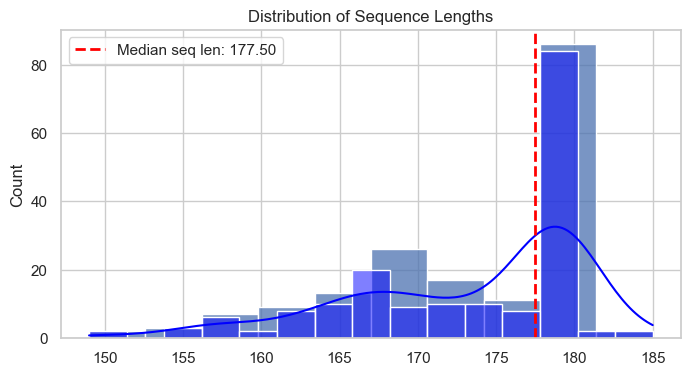

In [50]:
eda_obj.seq_lens_distrib()

### 2. Interactively explore each time-series variable and decompose it into trends, seasonality and residuals

In [51]:
# Create dropdown widget
dropdown = widgets.Dropdown(
    options= config['ts_cols'],
    value="SPARGE_O2",
    description="Select Column:",
    style={'description_width': 'initial'})

# Use interact to link dropdown and plotting function
interact(eda_obj.plot_ts_data, column=dropdown)

interactive(children=(Dropdown(description='Select Column:', index=17, options=('AGIT', 'AGIT_SEAL_PRESS', 'DO…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

### 3. KDEs and Box-plots to look at variance in each Variable

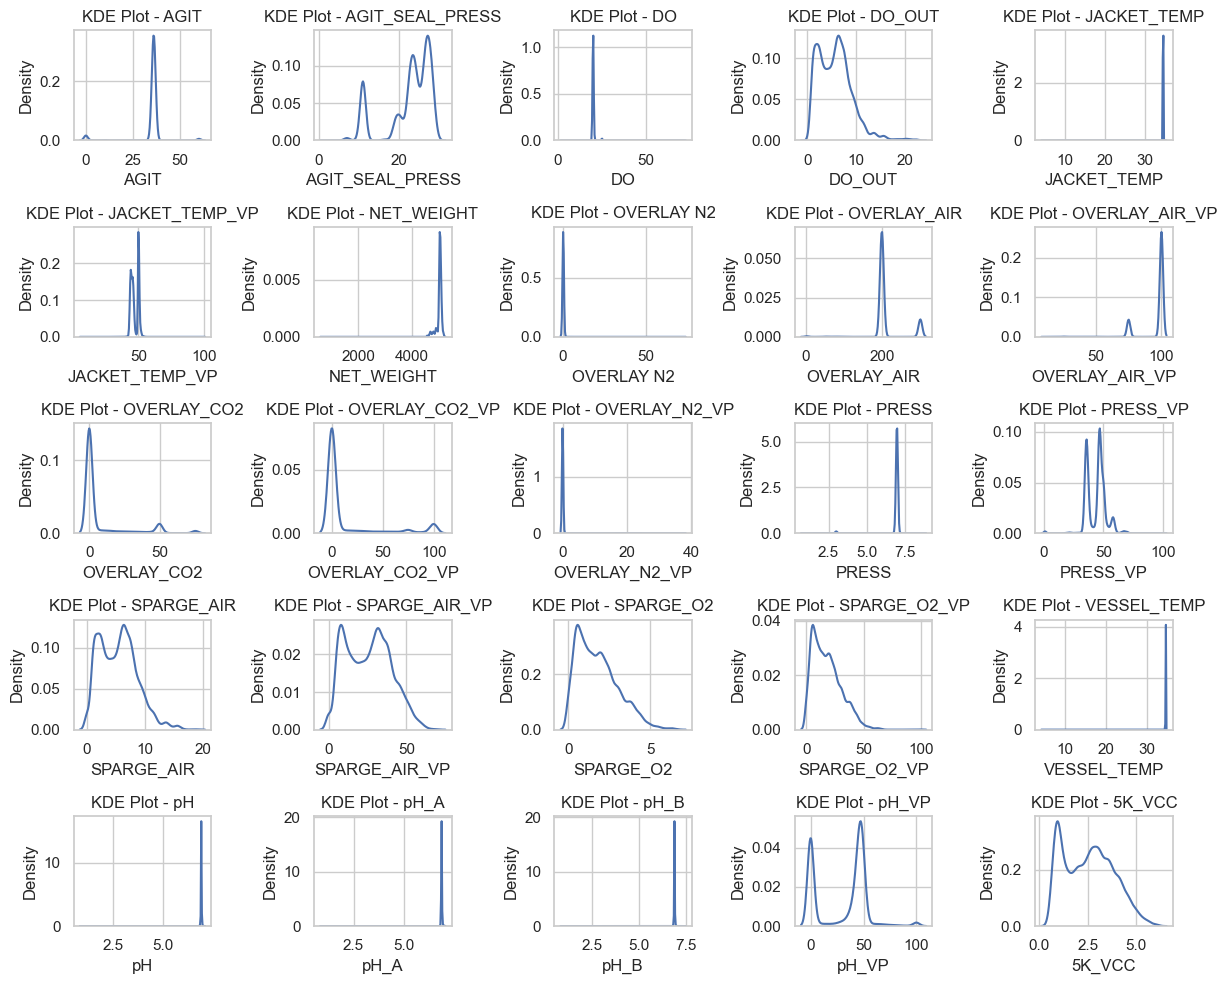

In [52]:
eda_obj.univariate_analysis_kde()

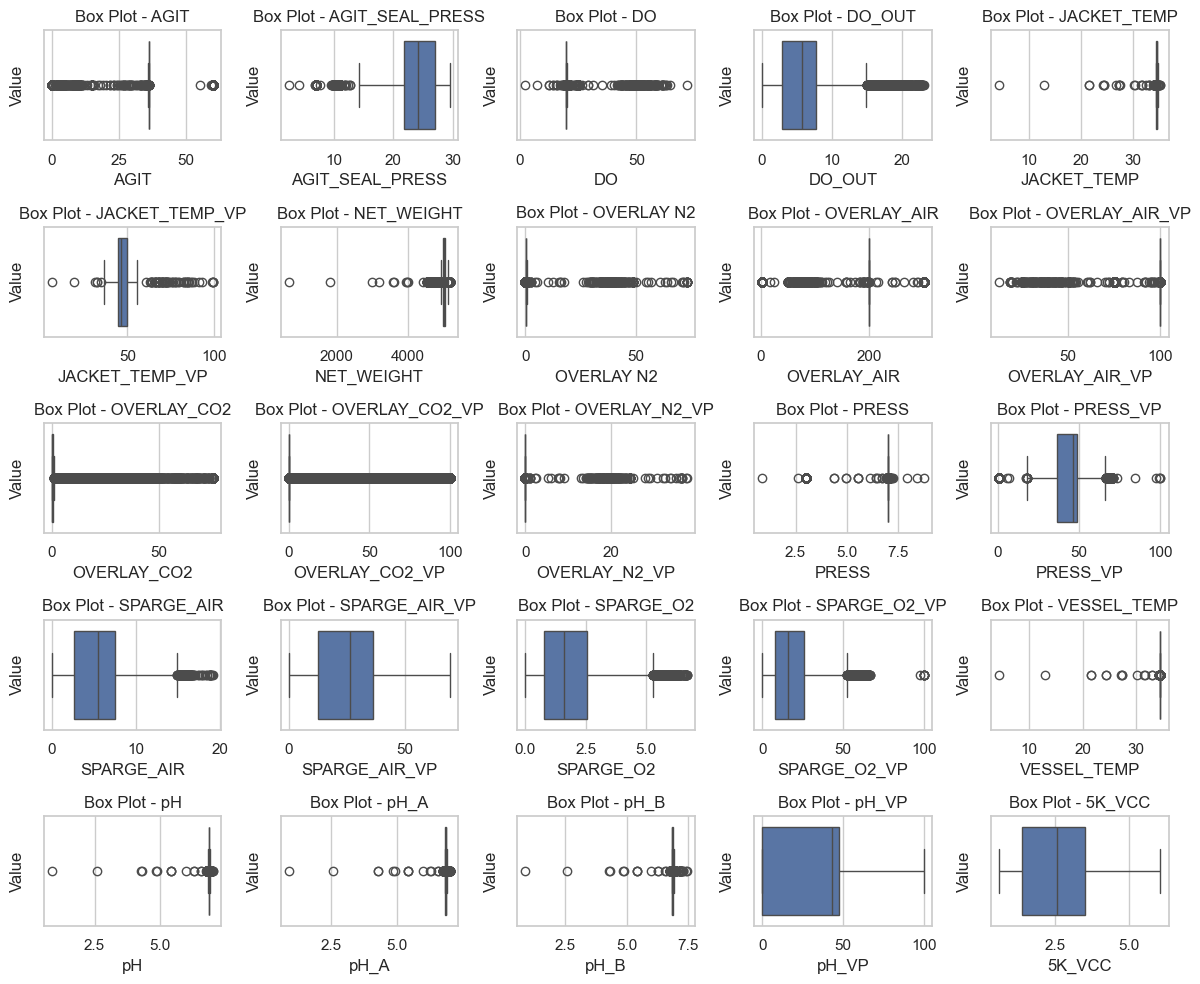

In [53]:
eda_obj.univariate_analysis_box()

### 4. Look at random time-series data across all variables

>> Plotting for the following batches:   ['J0420019', 'J0420006', 'J0418021', 'J0418004', 'J0420020']


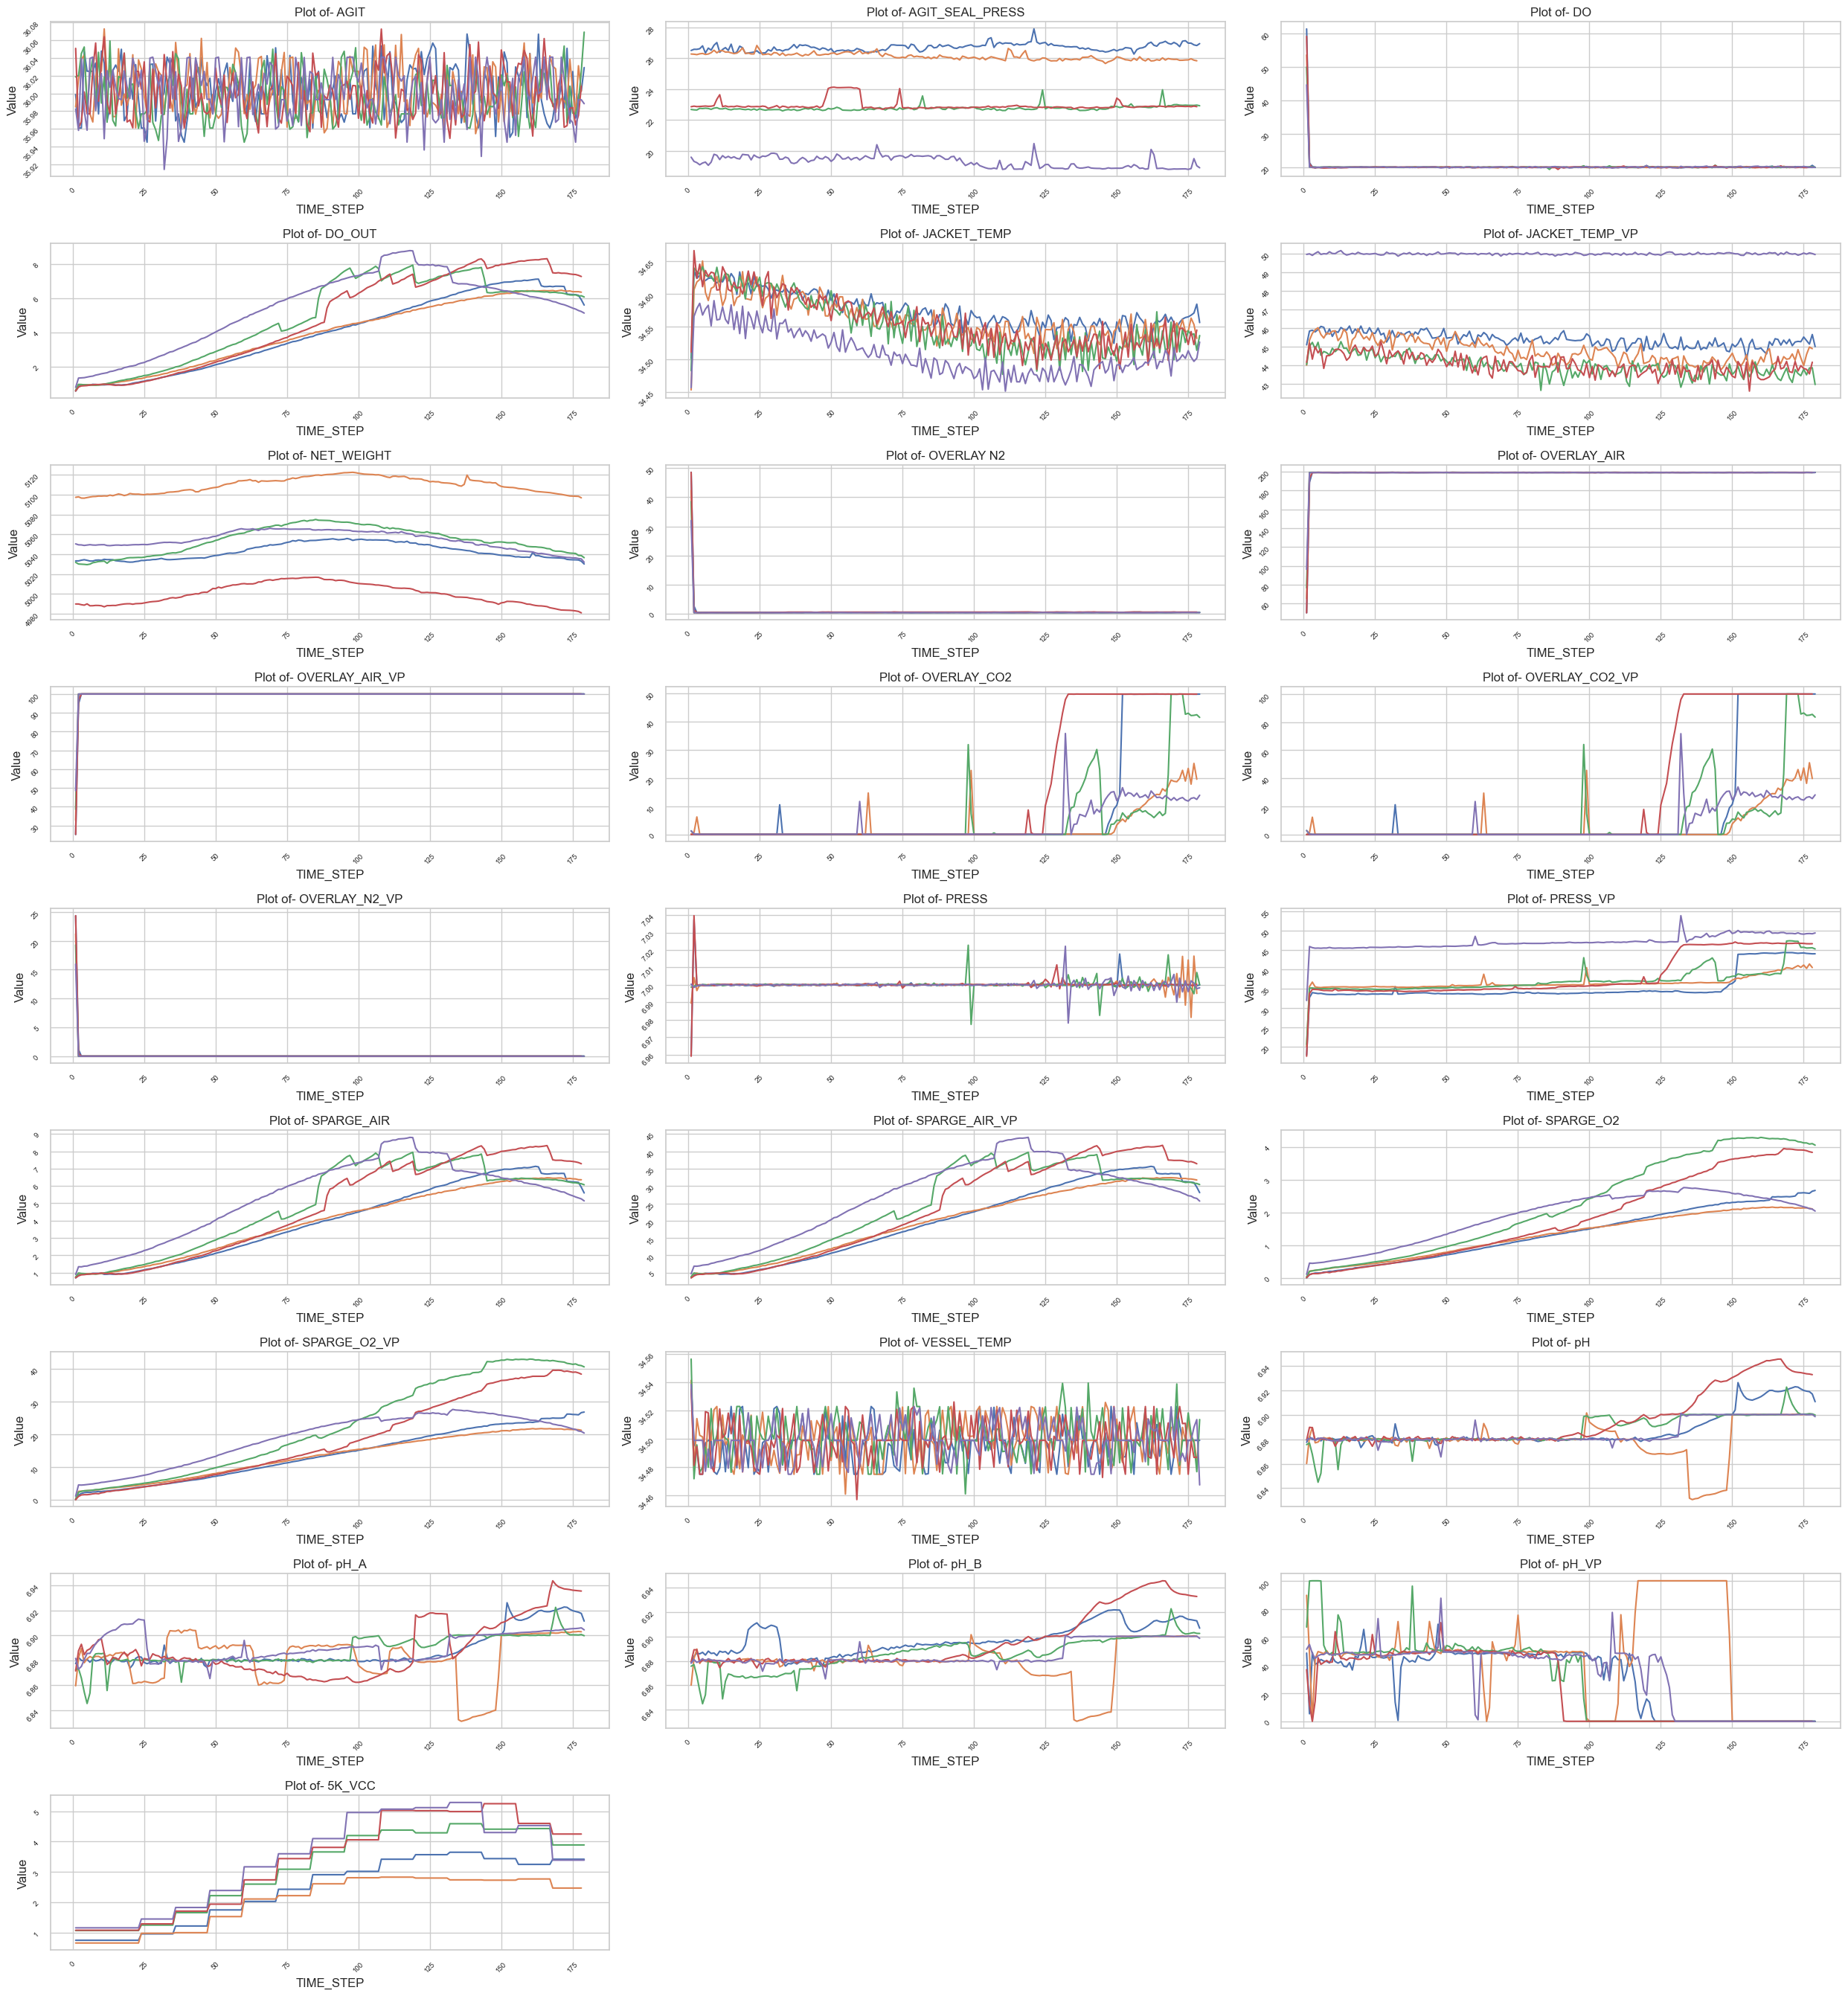

In [68]:
eda_obj.random_sumsample_time_series_plot(n_samples=5)

## Bi-Variate Analysis :  Look at correlations

### 1. Bi-variate correlations

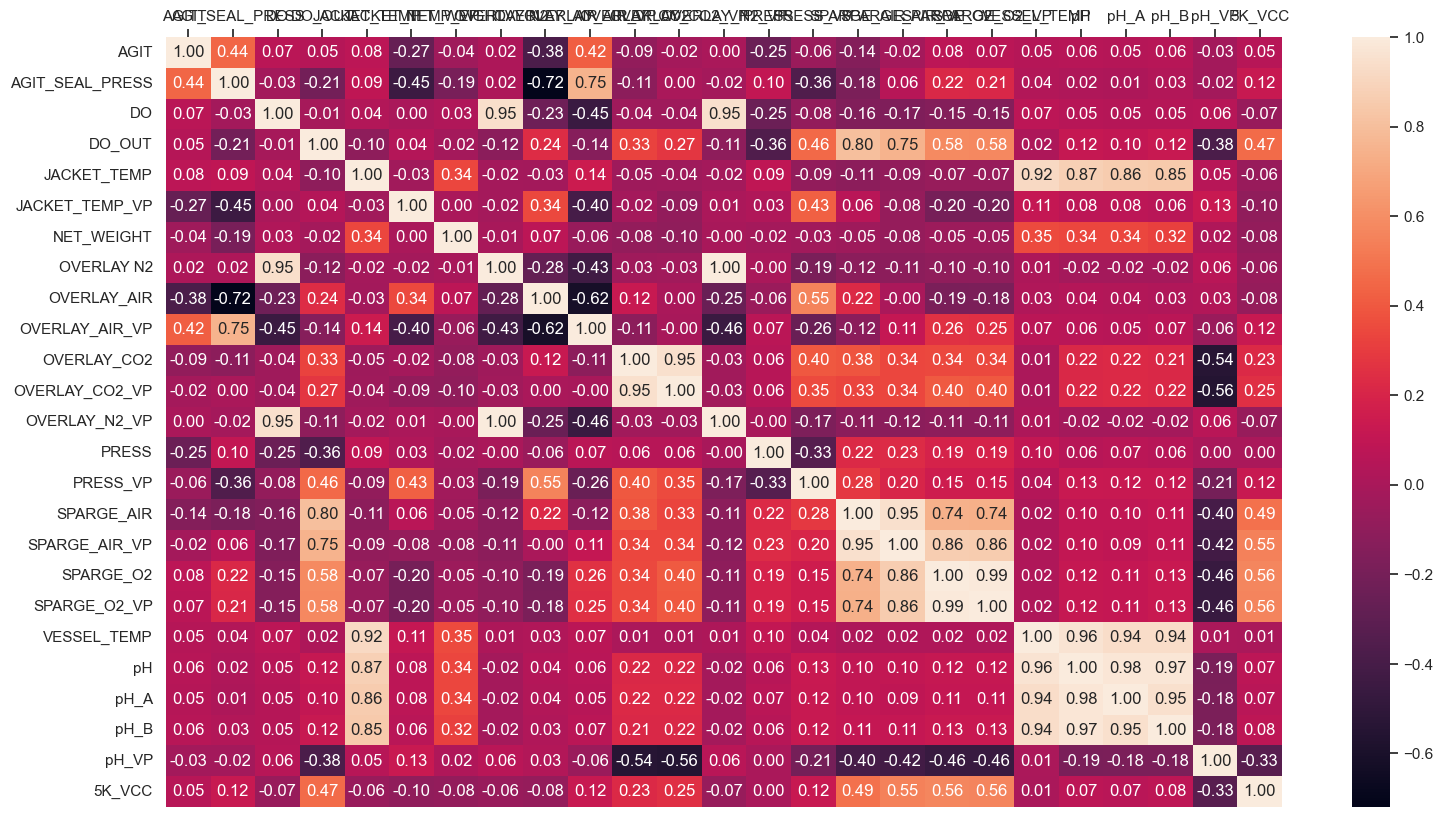

In [27]:
plt.figure(figsize=(18, 10))
ax = sns.heatmap(mv_ts[config['ts_cols']].corr(), fmt='.2f', annot=True)
ax.xaxis.tick_top()

### 2. Correlation between the target variable and some meta-data variable

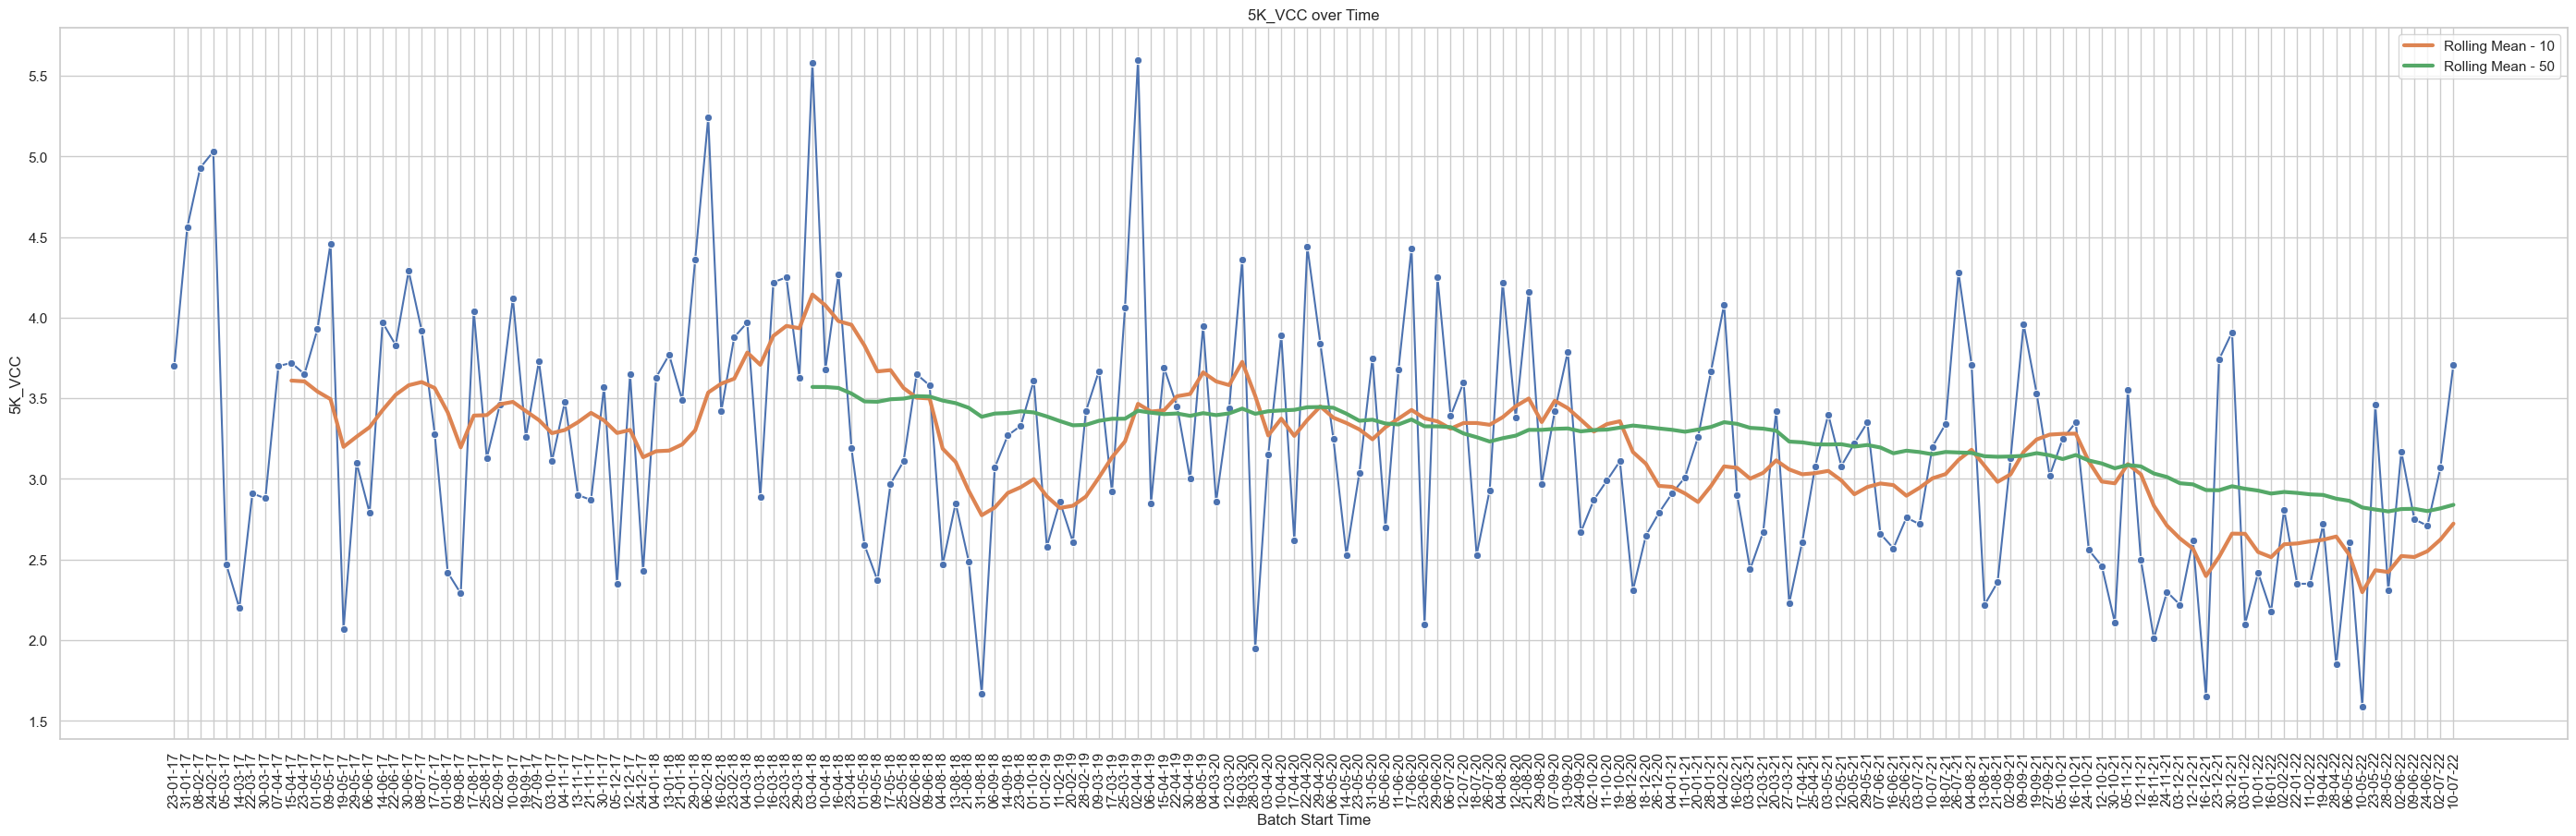

In [30]:
merged_df = eda_obj.batch_start_time_corr_with_yield()

<Axes: >

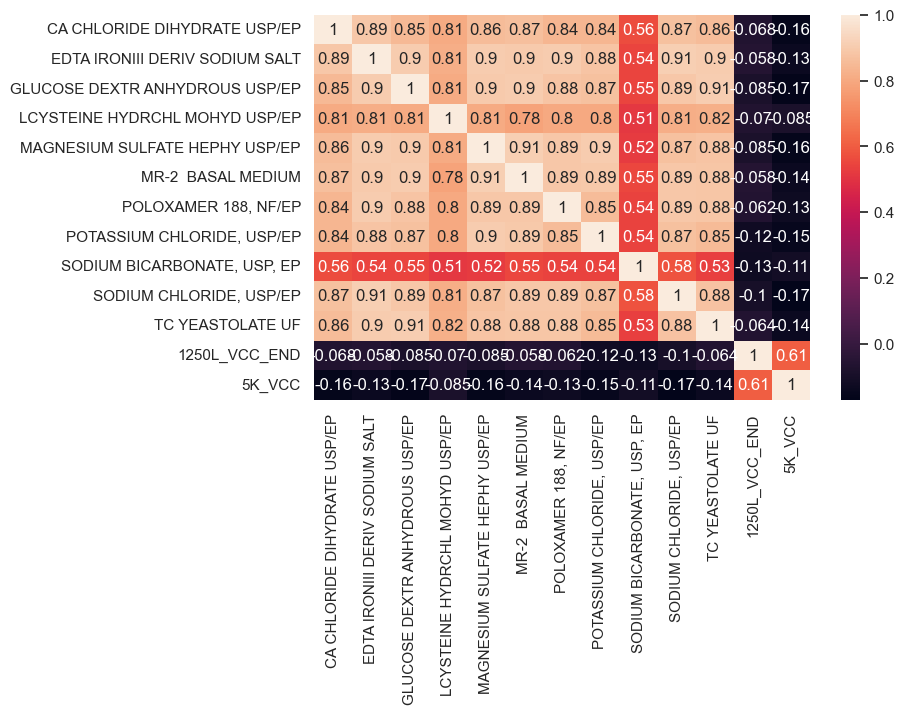

In [31]:
corr_cols = [c for c in eda_obj.merged_df.columns if c not in [config['seq_identifier_col'], 'START_TIME']]

plt.figure(figsize=(8, 5))
sns.heatmap(eda_obj.merged_df[corr_cols].corr(), annot=True)

## Check Auto-Correlation Factor (ACF) and PACF

In [32]:
# Create dropdown widget
dropdown = widgets.Dropdown(
    options= config['ts_cols'],
    value="SPARGE_O2",
    description="Select Column:",
    style={'description_width': 'initial'})

# Use interact to link dropdown and plotting function
interact(eda_obj.plot_acf_pacf, column=dropdown)

interactive(children=(Dropdown(description='Select Column:', index=17, options=('AGIT', 'AGIT_SEAL_PRESS', 'DO…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

### Check Variance Inflation Factor (VIF)

In [33]:
eda_obj.agg_vif()

            Feature           VIF
20               pH  1.416762e+06
19      VESSEL_TEMP  9.508033e+05
21             pH_A  3.346449e+05
22             pH_B  3.037607e+05
4       JACKET_TEMP  1.260061e+05
6        NET_WEIGHT  2.881387e+03
2                DO  2.216974e+03
13            PRESS  2.079605e+03
9    OVERLAY_AIR_VP  9.868376e+02
5    JACKET_TEMP_VP  5.747189e+02
15       SPARGE_AIR  2.974379e+02
16    SPARGE_AIR_VP  2.522711e+02
8       OVERLAY_AIR  2.423548e+02
7        OVERLAY N2  2.258855e+02
12    OVERLAY_N2_VP  2.221510e+02
17        SPARGE_O2  1.874349e+02
18     SPARGE_O2_VP  1.698156e+02
14         PRESS_VP  1.355739e+02
3            DO_OUT  9.652404e+01
1   AGIT_SEAL_PRESS  7.180349e+01
0              AGIT  2.937897e+01
24           5K_VCC  2.257991e+01
10      OVERLAY_CO2  2.153923e+01
11   OVERLAY_CO2_VP  2.057492e+01
23            pH_VP  6.130859e+00


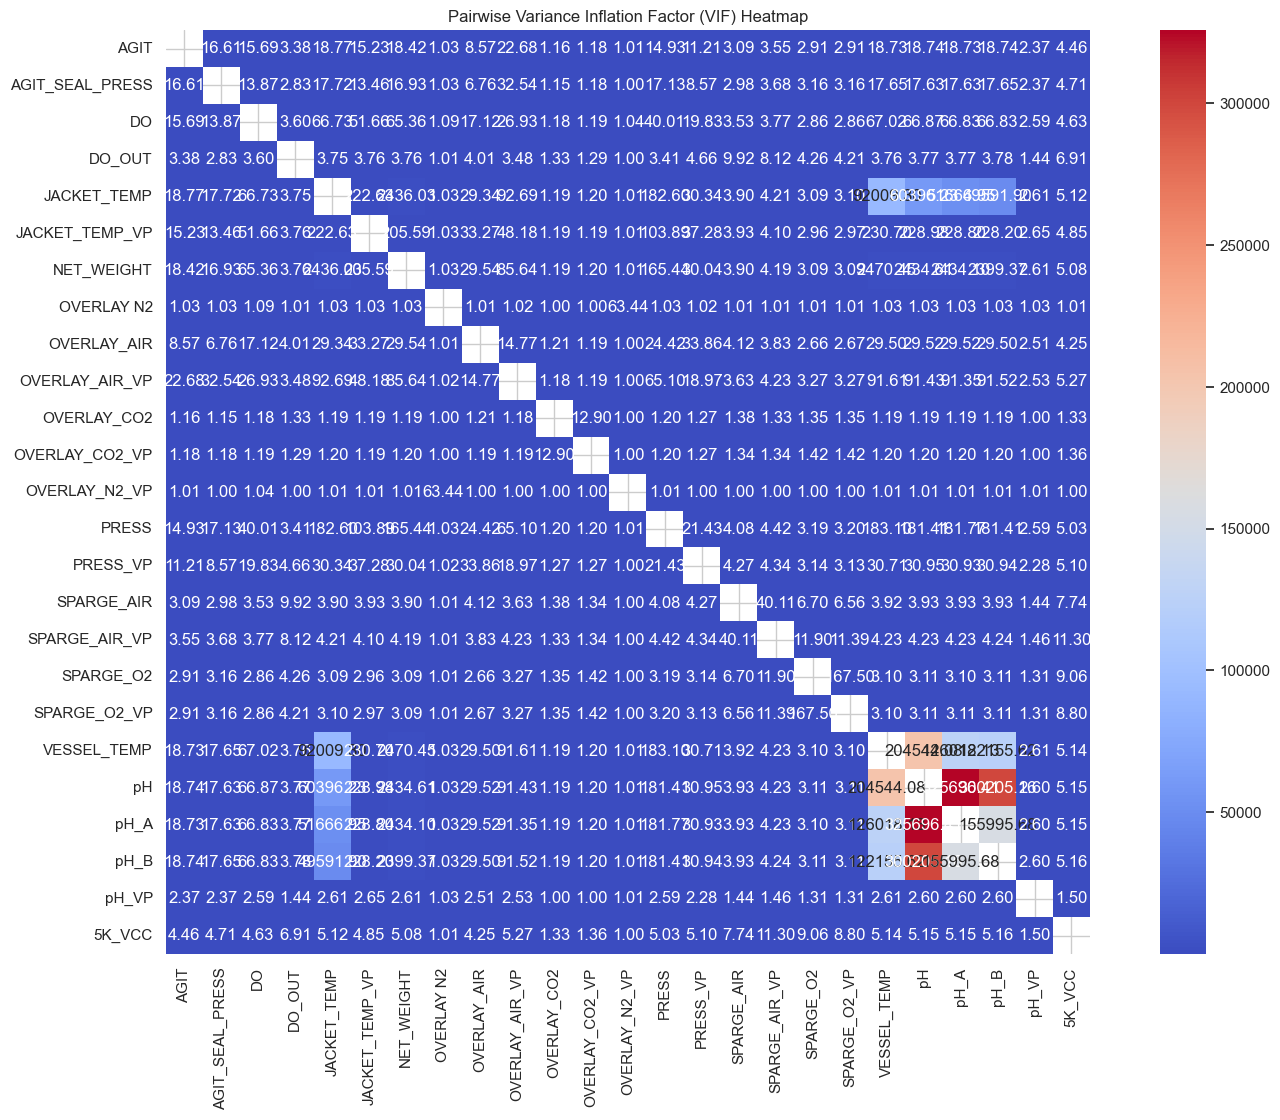

In [70]:
eda_obj.plot_pairwise_vif()

In [35]:
# sns.pairplot(eda_obj.mv_ts[config['ts_cols'][:7]], corner=True)

## Cluster similar time-series (based on meta data)

{'seq_data_path': 'data/batch_data_5K_120_seq_v2.csv', 'static_data_path': 'data/batch_data_5K_static_v2.csv', 'seq_identifier_col': 'BATCH_ID', 'time_step_col': 'TIME_STEP', 'cols_to_drop': 'PROCESS', 'ts_cols': ['AGIT', 'AGIT_SEAL_PRESS', 'DO', 'DO_OUT', 'JACKET_TEMP', 'JACKET_TEMP_VP', 'NET_WEIGHT', 'OVERLAY N2', 'OVERLAY_AIR', 'OVERLAY_AIR_VP', 'OVERLAY_CO2', 'OVERLAY_CO2_VP', 'OVERLAY_N2_VP', 'PRESS', 'PRESS_VP', 'SPARGE_AIR', 'SPARGE_AIR_VP', 'SPARGE_O2', 'SPARGE_O2_VP', 'VESSEL_TEMP', 'pH', 'pH_A', 'pH_B', 'pH_VP', '5K_VCC']}


c:\Users\SC26218\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\SC26218\Desktop\practice\multivariate_timeseries_cheatsheet\ts_clustering.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.meta_data['Cluster'] = clusters


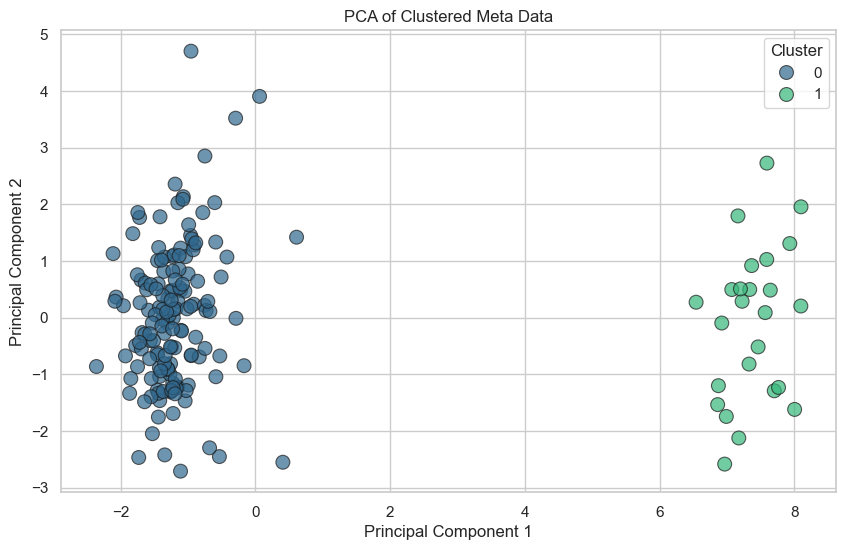

In [36]:
cluster_obj = Multivariate_TS_Clustering(config, eda_obj.mv_ts, eda_obj.merged_df[corr_cols])
meta_data_clustered, kmeans_model = cluster_obj.KMeans_cluster_meta_data(n_clusters=2)
cluster_obj.perform_pca_and_plot(n_components=2)

>> Cluster 0 avg yield =  3.16,   Median yield =  3.11 
>> Cluster 1 avg yield =  3.49,   Median yield =  3.70 





<Figure size 2000x1000 with 0 Axes>

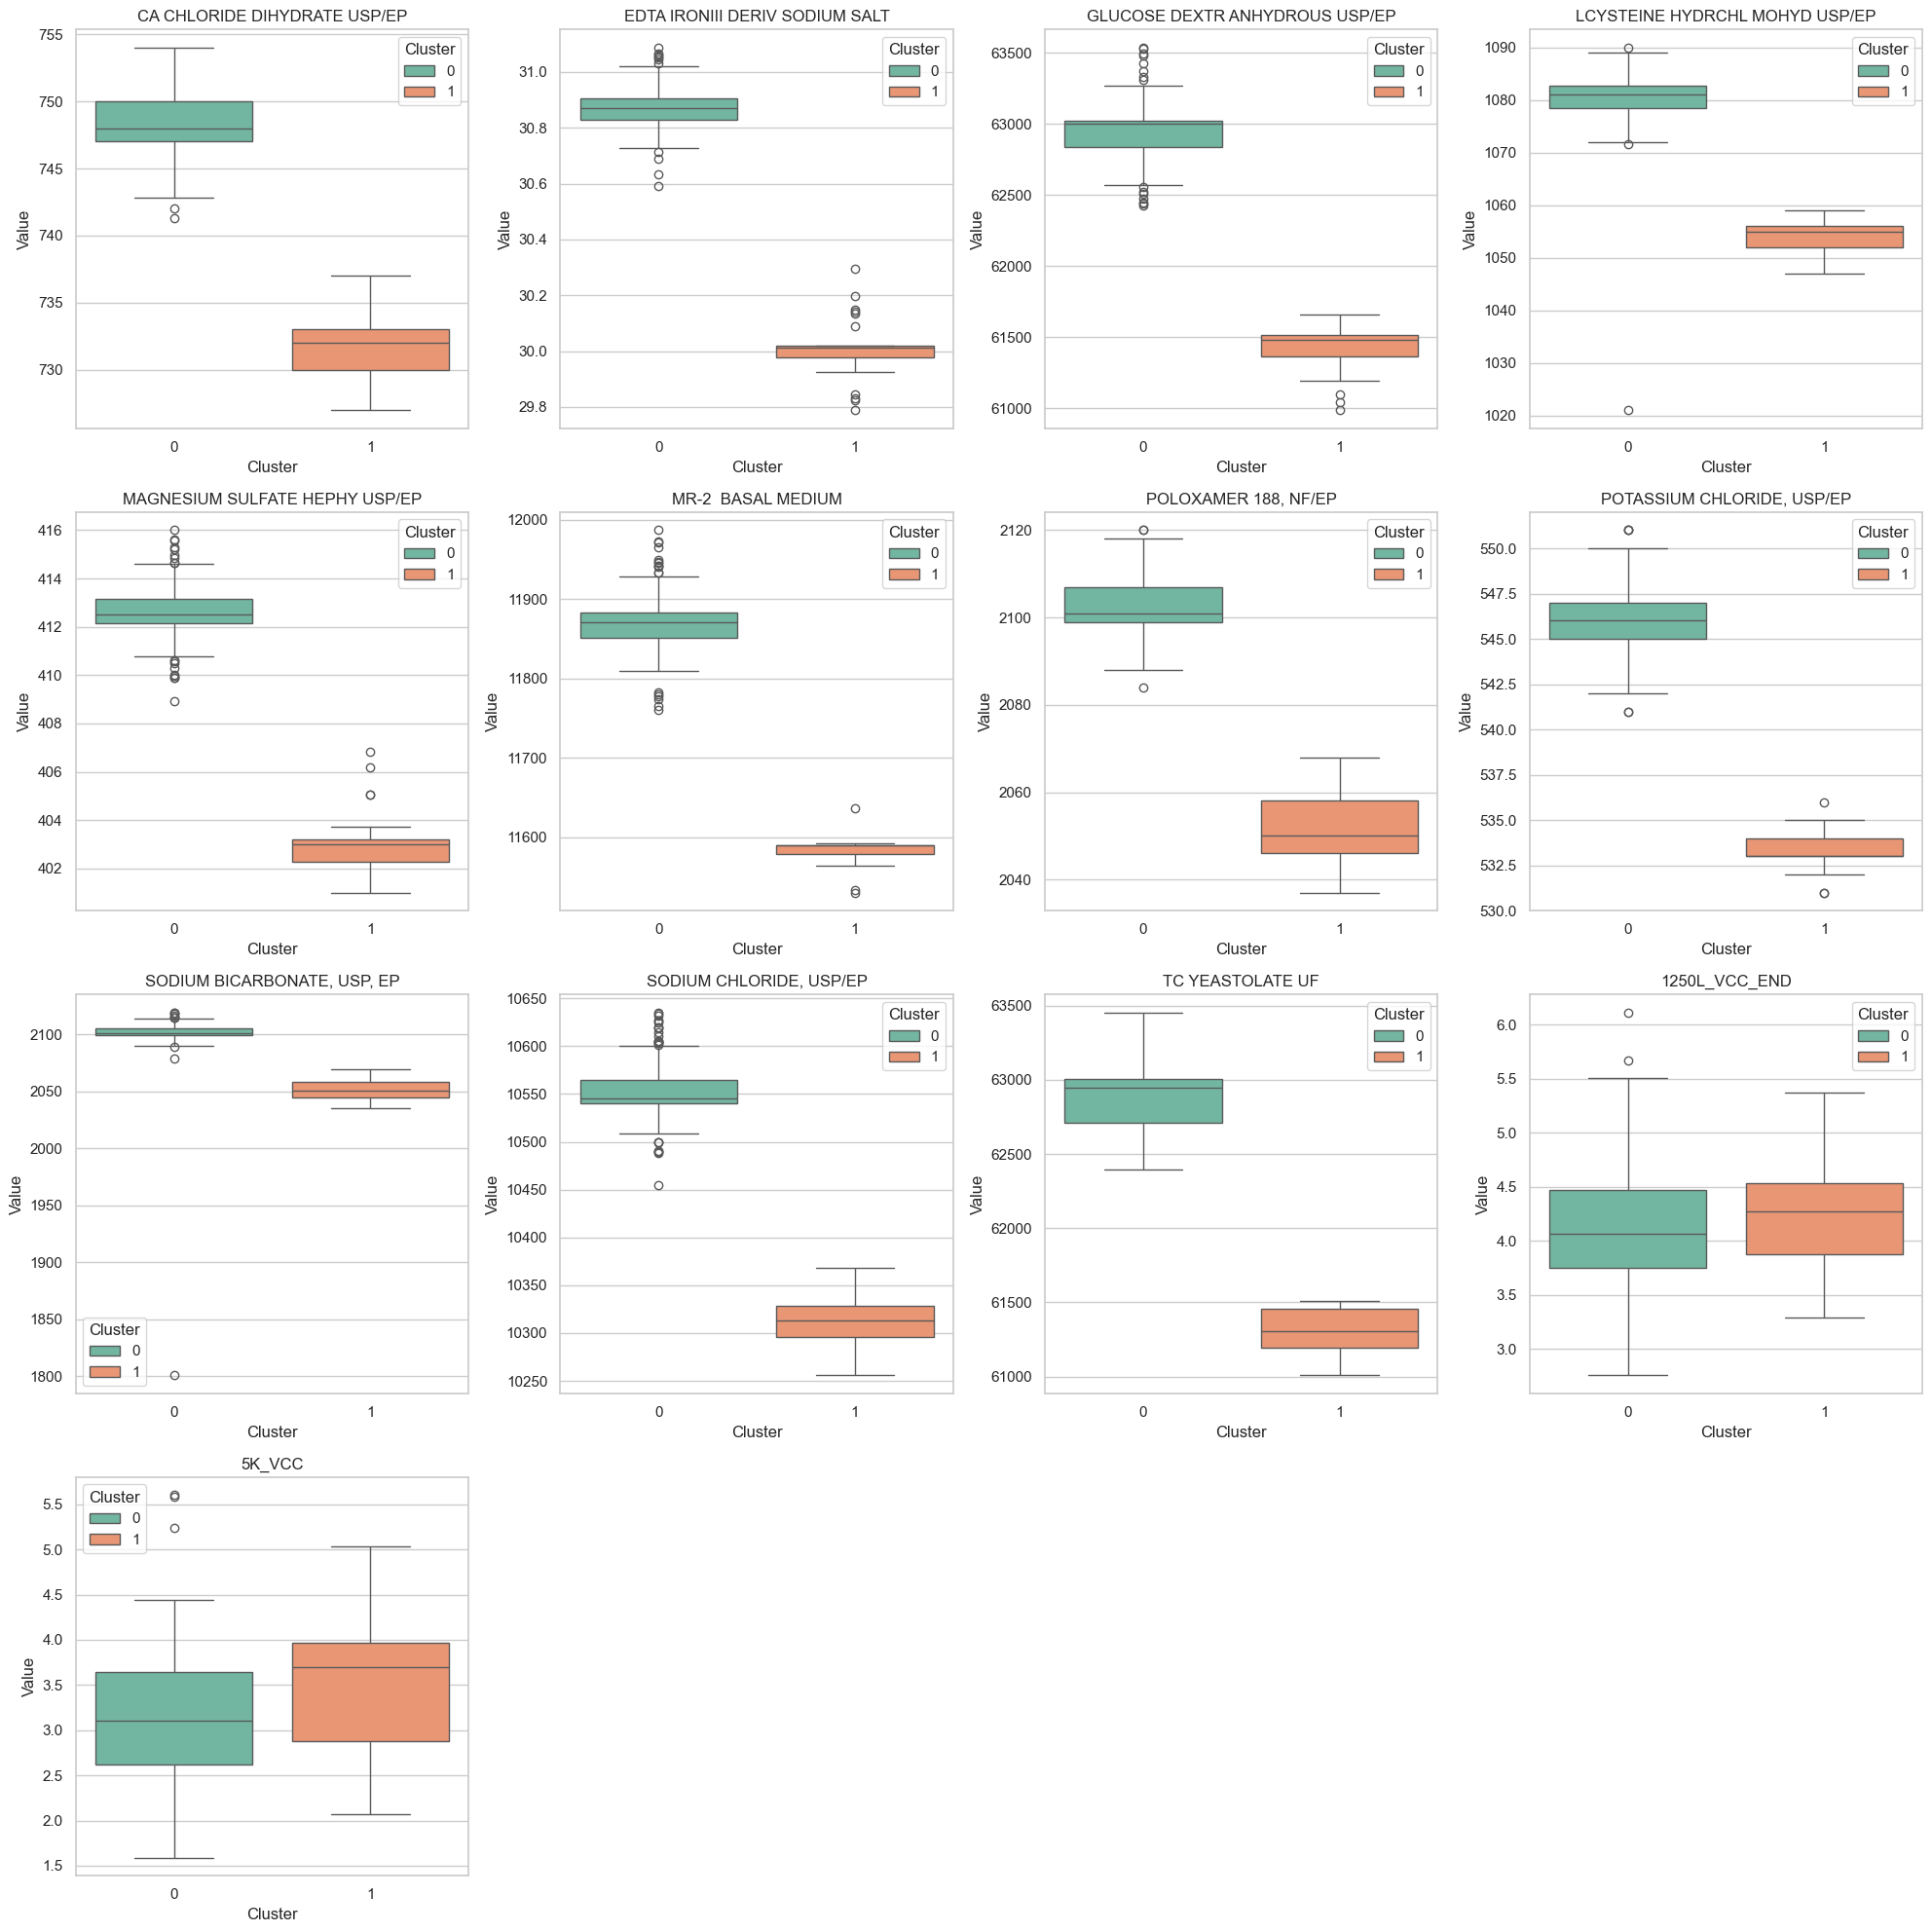

In [37]:
print(f">> Cluster 0 avg yield = {cluster_obj.meta_data[cluster_obj.meta_data['Cluster'] == 0]['5K_VCC'].mean() : .2f},   Median yield = {cluster_obj.meta_data[cluster_obj.meta_data['Cluster'] == 0]['5K_VCC'].median() : .2f} ")
print(f">> Cluster 1 avg yield = {cluster_obj.meta_data[cluster_obj.meta_data['Cluster'] == 1]['5K_VCC'].mean() : .2f},   Median yield = {cluster_obj.meta_data[cluster_obj.meta_data['Cluster'] == 1]['5K_VCC'].median() : .2f} ")
print("\n\n")
cluster_obj.visualize_cluster_differences()

In [38]:
eda_obj.meta_data['Cluster'] = cluster_obj.meta_data['Cluster'].astype(str)

### 3. See how clusters are assigned to batches over time

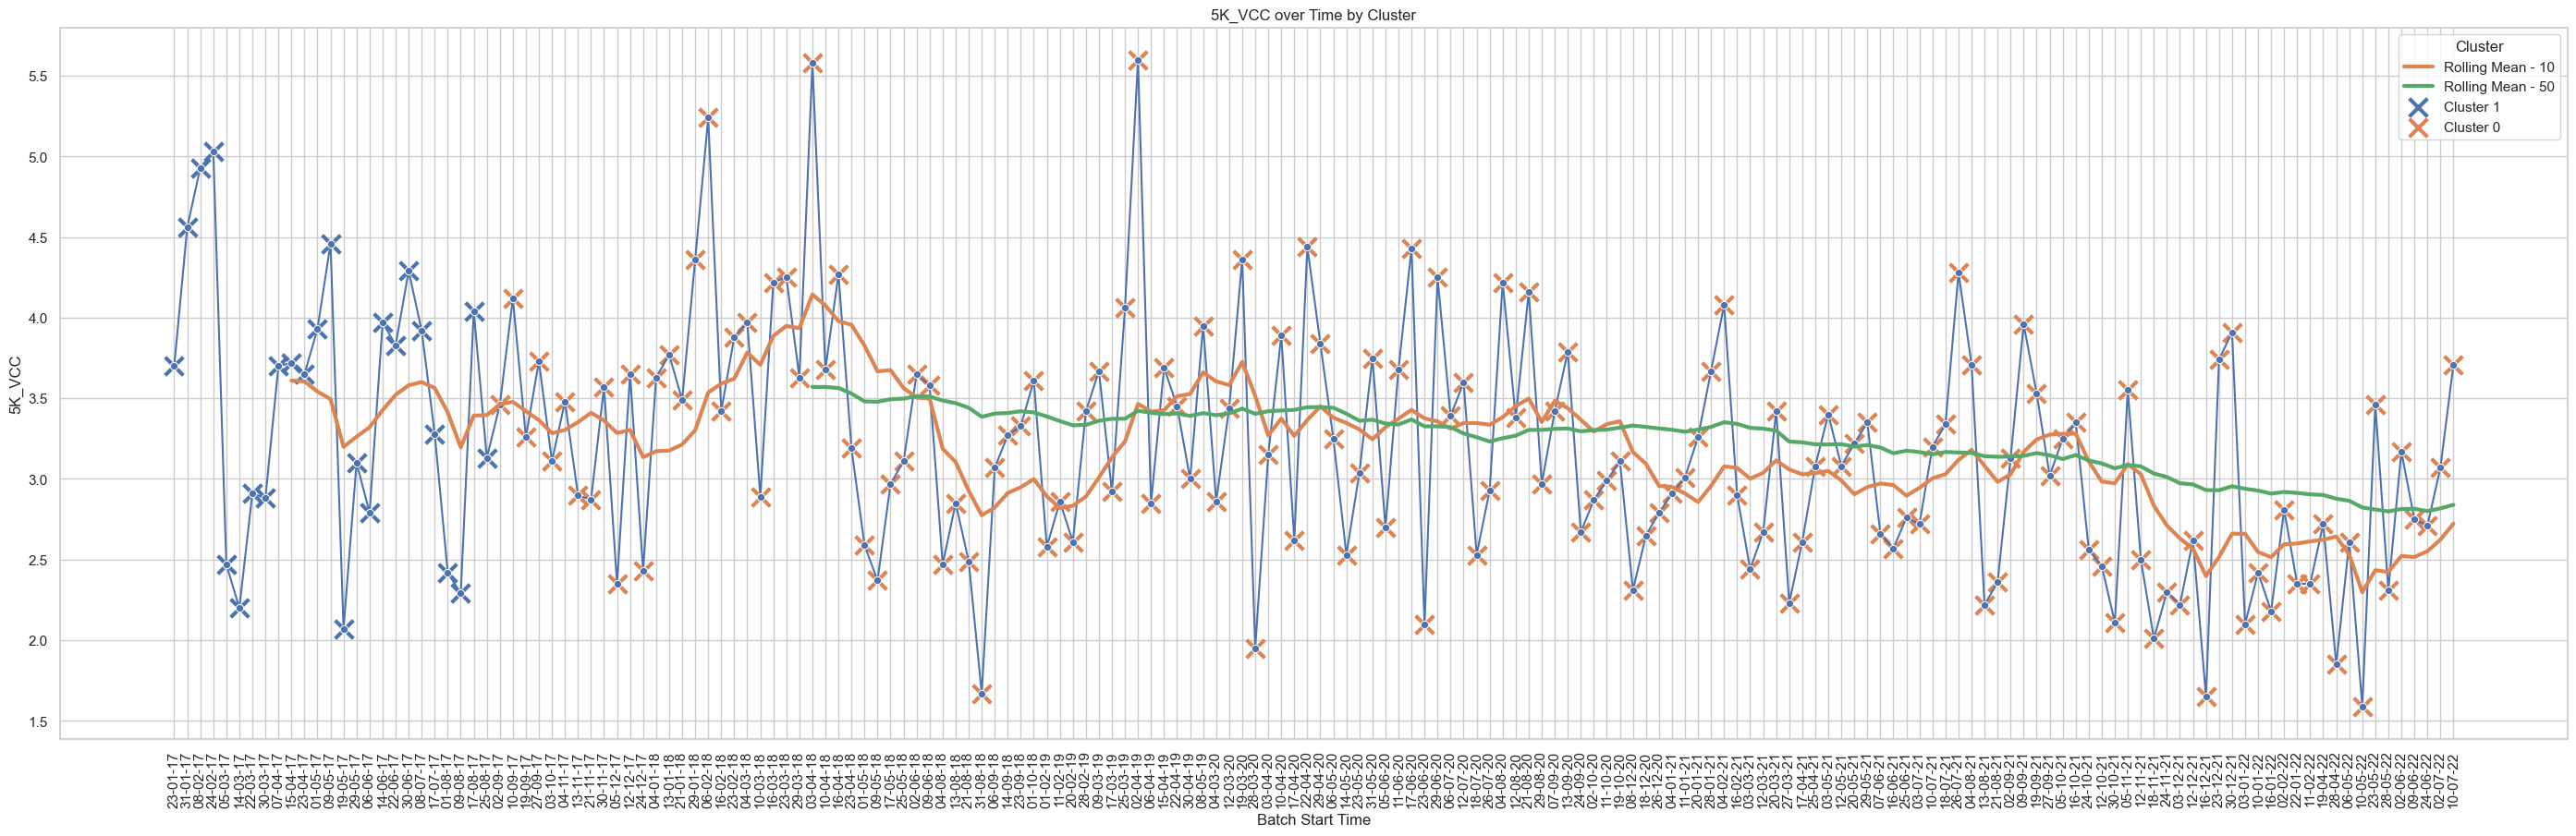

In [39]:
eda_obj.batch_start_time_corr_with_yield(cluster_plots=True)

## Cluster similar time-series (based on time-series data)

### 1. First, visualize the multi-variate TS data as an image to look at visible patterns and trends

In [40]:
# Create dropdown widget
dropdown = widgets.Dropdown(
    options= eda_obj.mv_ts[config['seq_identifier_col']].unique(),
    value="J0417001",
    description="Select Batch to visualize:",
    style={'description_width': 'initial'})


# Use interact to link dropdown and plotting function
interact(cluster_obj.plot_multivariate_ts_as_image, selected_batch_id=dropdown)




interactive(children=(Dropdown(description='Select Batch to visualize:', options=('J0417001', 'J0417002', 'J04…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

### 2. Apply a CNN-based Auto-encoder to obtain latent embeddings of each sequence.

In [41]:
# Hyperparameters
config['input_channels'] = 1 # len(config['ts_cols'])
config['learning_rate'] = 0.001
config['num_epochs'] = 5000
config['batch_size'] = 16
config['model_save_path'] = "./model_checkpoints/test.pt"

cluster_obj.prepare_data()
cluster_obj.prepare_model_and_optmzr()

--------------------------------------------------
Preparing data for training the CNN Autoencoder
--------------------------------------------------
>> Max len seq for padding the rest =  185
>> The 3D tensor constructed (num_seqs, num_cols, max_time_steps) =  torch.Size([176, 25, 185])
>> Data prepared for training the CNN Autoencoder

--------------------------------------------------
Initializing models and optimizers for training the CNN Autoencoder
--------------------------------------------------
>> Model architecture: 
 CNNAutoencoder(
  (cnnencoder): CNNEncoder(
    (encoder): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  )
  (cnndecoder): CNNDecoder(
    (decoder): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(

c:\Users\SC26218\Desktop\practice\multivariate_timeseries_cheatsheet\ts_clustering.py:239: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  self.mv_ts_tensor = torch.tensor(padded_sequences).permute(0, 2, 1).float()


Epoch 1, Loss: 939014.6591
>> Current best model at epoch 0 and loss  939014.6591
Epoch 21, Loss: 2129.2569
Epoch 41, Loss: 698.2120
Epoch 61, Loss: 372.7429
Epoch 81, Loss: 246.5847
Epoch 101, Loss: 197.9002
>> Current best model at epoch 100 and loss  197.9002
Epoch 121, Loss: 168.9547
Epoch 141, Loss: 165.5414
Epoch 161, Loss: 147.2288
Epoch 181, Loss: 141.0626
Epoch 201, Loss: 139.9030
>> Current best model at epoch 187 and loss  128.7130
Epoch 221, Loss: 149.2344
Epoch 241, Loss: 124.0200
Epoch 261, Loss: 127.3526
Epoch 281, Loss: 113.6484
Epoch 301, Loss: 116.6097
>> Current best model at epoch 298 and loss  101.9742
Epoch 321, Loss: 97.7023
Epoch 341, Loss: 106.4291
Epoch 361, Loss: 98.3092
Epoch 381, Loss: 80.7358
Epoch 401, Loss: 82.0482
>> Current best model at epoch 394 and loss  70.1474
Epoch 421, Loss: 66.7387
Epoch 441, Loss: 55.6235
Epoch 461, Loss: 124.8187
Epoch 481, Loss: 40.6154
Epoch 501, Loss: 43.8919
>> Current best model at epoch 489 and loss  39.5150
Epoch 521, 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



>> Final Epoch, Loss: 5.6956


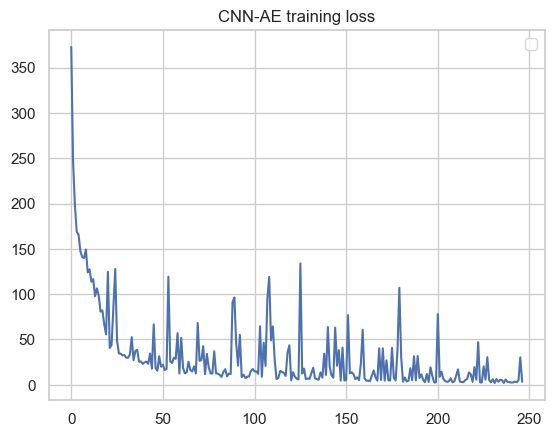

In [42]:
outputs = cluster_obj.train_CNN_AE()